### A notebook to test out the workflow of using a data.gov.sg API

In [31]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [52]:
def make_folder(list):
    for i in list:
        if not os.path.exists(i):
            os.makedirs(i)
            print("folder is created: " + i)

#create some folders to copy the data to
dir_create = ['data', 'models', 'raw', 'processed', 'output']
dir_raw_data = 'data/raw'
dir_processed = 'data/processed'

folder_list = ['data','models','logs', 'output']

make_folder(folder_list)


folder is created: output


Data source link is https://data.gov.sg/dataset/resale-flat-prices?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee

In [33]:
#retrieve some data 
#query is based on record count


records =100000
api1 = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit='+str(records)
api2 = ''
api3 = ''

#link: https://data.gov.sg/dataset/resale-flat-prices?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee
res = requests.get(api1)
#res = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=10')
#string search
#res = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&q=2019')
data = res.json()
#data


#### Get some sample records

In [34]:
#sample records 
data['result']['records'][0:2]

[{'town': 'ANG MO KIO',
  'flat_type': '2 ROOM',
  'flat_model': 'Improved',
  'floor_area_sqm': '44',
  'street_name': 'ANG MO KIO AVE 10',
  'resale_price': '232000',
  'month': '2017-01',
  'remaining_lease': '61 years 04 months',
  'lease_commence_date': '1979',
  'storey_range': '10 TO 12',
  '_id': 1,
  'block': '406'},
 {'town': 'ANG MO KIO',
  'flat_type': '3 ROOM',
  'flat_model': 'New Generation',
  'floor_area_sqm': '67',
  'street_name': 'ANG MO KIO AVE 4',
  'resale_price': '250000',
  'month': '2017-01',
  'remaining_lease': '60 years 07 months',
  'lease_commence_date': '1978',
  'storey_range': '01 TO 03',
  '_id': 2,
  'block': '108'}]

#### Convert the dictionary into a dataframe

Convert the data types as well

In [35]:
col_num = ['floor_area_sqm', 'resale_price']
col_dates = ['month', 'lease_commence_date']
col_cat = ['town','flat_type','block','street_name','storey_range','flat_model']

data_1 = pd.DataFrame.from_dict(data['result']['records'])
data_1.head()

for var in col_dates:
   data_1[var] = data_1[var].astype('datetime64[ns]')

for var in col_num:
   data_1[var] = data_1[var].astype('float64')

for var in col_cat:
   data_1[var] = data_1[var].astype('category')

data_1.info()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,2 ROOM,Improved,44,ANG MO KIO AVE 10,232000,2017-01,61 years 04 months,1979,10 TO 12,1,406
1,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 4,250000,2017-01,60 years 07 months,1978,01 TO 03,2,108
2,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,262000,2017-01,62 years 05 months,1980,01 TO 03,3,602
3,ANG MO KIO,3 ROOM,New Generation,68,ANG MO KIO AVE 10,265000,2017-01,62 years 01 month,1980,04 TO 06,4,465
4,ANG MO KIO,3 ROOM,New Generation,67,ANG MO KIO AVE 5,265000,2017-01,62 years 05 months,1980,01 TO 03,5,601


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70879 entries, 0 to 70878
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   town                 70879 non-null  category      
 1   flat_type            70879 non-null  category      
 2   flat_model           70879 non-null  category      
 3   floor_area_sqm       70879 non-null  float64       
 4   street_name          70879 non-null  category      
 5   resale_price         70879 non-null  float64       
 6   month                70879 non-null  datetime64[ns]
 7   remaining_lease      70879 non-null  object        
 8   lease_commence_date  70879 non-null  datetime64[ns]
 9   storey_range         70879 non-null  category      
 10  _id                  70879 non-null  int64         
 11  block                70879 non-null  category      
dtypes: category(6), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 3.9+ MB

Drop the column remaining_lease as it is a string, recalculate based on month and lease_commence date


Add feature

Number of years remaining Number of months remaining

Drop the original column - remaining lease ,as it was in text form

Add feature - Year the flat was sold


In [36]:
data_1['years_remaining'] = data_1['month'].dt.year - data_1['lease_commence_date'].dt.year
data_1['months_remaining'] = ((data_1['month'] - data_1['lease_commence_date'])/np.timedelta64(1, 'M')).astype(int)
data_1['year_sold'] = data_1['month'].dt.year
data_1.drop('remaining_lease', axis=1, inplace=True)

data_1.head()
data_1.info()
print("Data up to : {}".format(data_1["month"].max()))

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,years_remaining,months_remaining,year_sold
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01-01,1979-01-01,10 TO 12,1,406,38,456,2017
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01-01,1978-01-01,01 TO 03,2,108,39,468,2017
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01-01,1980-01-01,01 TO 03,3,602,37,444,2017
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01-01,1980-01-01,04 TO 06,4,465,37,444,2017
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01-01,1980-01-01,01 TO 03,5,601,37,444,2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70879 entries, 0 to 70878
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   town                 70879 non-null  category      
 1   flat_type            70879 non-null  category      
 2   flat_model           70879 non-null  category      
 3   floor_area_sqm       70879 non-null  float64       
 4   street_name          70879 non-null  category      
 5   resale_price         70879 non-null  float64       
 6   month                70879 non-null  datetime64[ns]
 7   lease_commence_date  70879 non-null  datetime64[ns]
 8   storey_range         70879 non-null  category      
 9   _id                  70879 non-null  int64         
 10  block                70879 non-null  category      
 11  years_remaining      70879 non-null  int64         
 12  months_remaining     70879 non-null  int64         
 13  year_sold            70879 non-

Check for missing values 

In [37]:
data_1.isnull().sum()>0

town                   False
flat_type              False
flat_model             False
floor_area_sqm         False
street_name            False
resale_price           False
month                  False
lease_commence_date    False
storey_range           False
_id                    False
block                  False
years_remaining        False
months_remaining       False
year_sold              False
dtype: bool

Let's try to categorise the apartment floor into categories

In [38]:
data_1['storey_start'] = data_1['storey_range'].str[0:2].astype(int)
data_1['storey_end']   = data_1['storey_range'].str[-2:].astype(int)

In [39]:
data_1.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,years_remaining,months_remaining,year_sold,storey_start,storey_end
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01-01,1979-01-01,10 TO 12,1,406,38,456,2017,10,12
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01-01,1978-01-01,01 TO 03,2,108,39,468,2017,1,3
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01-01,1980-01-01,01 TO 03,3,602,37,444,2017,1,3
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01-01,1980-01-01,04 TO 06,4,465,37,444,2017,4,6
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01-01,1980-01-01,01 TO 03,5,601,37,444,2017,1,3


In [40]:
highest_floor_of_town = pd.DataFrame(data_1.groupby('town')['storey_start'].max().astype(int)/3*2)
highest_floor_of_town.columns=['high_floor_cap']
mid_floor_of_town = round(highest_floor_of_town/2,0)

low_floor_of_town = pd.DataFrame(round(highest_floor_of_town/3,0))
low_floor_of_town.columns=['low_floor_cap']

#add back the calculated values to the dataset
data_1 = pd.merge(left=data_1, right=highest_floor_of_town, how='left',on='town')
#data_1.head()
data_2 = pd.merge(left=data_1, right=low_floor_of_town, how='left',on='town')
data_2.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,years_remaining,months_remaining,year_sold,storey_start,storey_end,high_floor_cap,low_floor_cap
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01-01,1979-01-01,10 TO 12,1,406,38,456,2017,10,12,18.666667,6.0
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01-01,1978-01-01,01 TO 03,2,108,39,468,2017,1,3,18.666667,6.0
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01-01,1980-01-01,01 TO 03,3,602,37,444,2017,1,3,18.666667,6.0
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01-01,1980-01-01,04 TO 06,4,465,37,444,2017,4,6,18.666667,6.0
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01-01,1980-01-01,01 TO 03,5,601,37,444,2017,1,3,18.666667,6.0


In [41]:

#data_1.drop("high_floor_y", axis=1, inplace=True)
#data1.rename(columns={"high_floor_cap_x":"high_floor_cap"})

#to do: add a num category for the floor


def classify_floor(x):
    #print (x)
    current = x['storey_start']
    cap = x['high_floor_cap']
    low = x['low_floor_cap']
    #print(cap)
    #print(low)
    #print (cap)
    if current > cap:
        return "high"
    elif current < low:
        return "low"
    else:
        return "mid"

#test_class = test_rows.apply(classify_floor, axis=1)
#test_rows['cat_floor'] = test_rows.apply(classify_floor, axis=1)
#test_rows

#%timeit data_2['cat_floor'] = data_2.apply(classify_floor, axis=1)
data_2['cat_floor'] = data_2.apply(classify_floor, axis=1)

print(data_2['cat_floor'].value_counts())

mid     39310
low     26590
high     4979
Name: cat_floor, dtype: int64


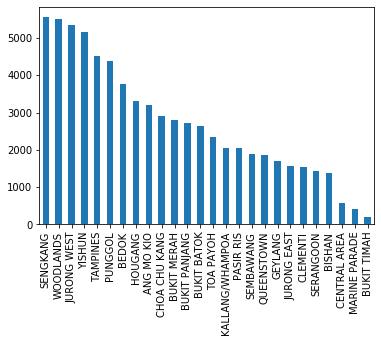

In [42]:
data_2['town'].value_counts().plot(kind='bar');


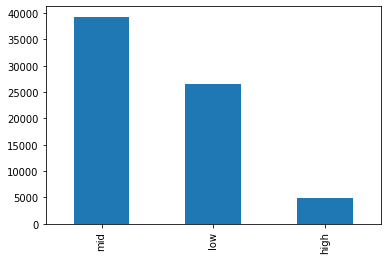

In [43]:
data_2['cat_floor'].value_counts().plot(kind='bar');

In [44]:
data_2.shape

(70879, 19)

In [45]:
data_2.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,lease_commence_date,storey_range,_id,block,years_remaining,months_remaining,year_sold,storey_start,storey_end,high_floor_cap,low_floor_cap,cat_floor
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01-01,1979-01-01,10 TO 12,1,406,38,456,2017,10,12,18.666667,6.0,mid
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01-01,1978-01-01,01 TO 03,2,108,39,468,2017,1,3,18.666667,6.0,low
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01-01,1980-01-01,01 TO 03,3,602,37,444,2017,1,3,18.666667,6.0,low
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01-01,1980-01-01,04 TO 06,4,465,37,444,2017,4,6,18.666667,6.0,low
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01-01,1980-01-01,01 TO 03,5,601,37,444,2017,1,3,18.666667,6.0,low


In [46]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70879 entries, 0 to 70878
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   town                 70879 non-null  category      
 1   flat_type            70879 non-null  category      
 2   flat_model           70879 non-null  category      
 3   floor_area_sqm       70879 non-null  float64       
 4   street_name          70879 non-null  category      
 5   resale_price         70879 non-null  float64       
 6   month                70879 non-null  datetime64[ns]
 7   lease_commence_date  70879 non-null  datetime64[ns]
 8   storey_range         70879 non-null  category      
 9   _id                  70879 non-null  int64         
 10  block                70879 non-null  category      
 11  years_remaining      70879 non-null  int64         
 12  months_remaining     70879 non-null  int64         
 13  year_sold            70879 non-

In [54]:
extract_mp = data_2[(data_2["town"]=="MARINE PARADE") &(data_2["year_sold"]>=2018) & (data_2["floor_area_sqm"]==120)].sort_values(by="resale_price")
extract_mp.to_csv("output/marine_parade_transactions.csv", index=False)

In [48]:
file_out = "/combined_clean_data.csv"

print(os.getcwd()+"/"+dir_processed +file_out)
path_out = os.getcwd()+"/"+dir_processed +file_out
data_2.to_csv(path_out,index=False)

/Users/g/Dropbox/DS_Projects/Exploring Resale Flat/data/processed/combined_clean_data.csv
